In [1]:
#https://www.kaggle.com/snap/amazon-fine-food-reviews
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,f1_score,accuracy_score,ConfusionMatrixDisplay,accuracy_score
from sklearn.utils import shuffle
import re

In [2]:
import pandas as pd
data = pd.read_csv('C:\\Users\\yazeed\\Downloads\\Reviews.csv\\Reviews.csv') #Read from CSV
data.head() #show first 5 rows

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [3]:
data.info() #Show more info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
# Product Scores
fig = px.histogram(data, x="Score")
fig.update_traces(marker_color="red",marker_line_color='rgb(9,44,207)',marker_line_width=1.5)
fig.update_layout(title_text='Product Score')
fig.show()

In [5]:
## from above figure, we can observe the score rating 5
Rating5 = data[data['Score']==5].count()['Score']
RatingNot5 = data[data['Score']<5].count()['Score']
print('The rating of five: ',Rating5)
print('The rating of less than five: ', RatingNot5)
print('Ratio of five: ', (Rating5-RatingNot5), ' is more than other ratings, showing it is very unbalanced dataset!')


Rating2 = data[data['Score']==2].count()['Score']

print('Rating 2 has the lowest with :,', Rating2 , ' ratings')

The rating of five:  363122
The rating of less than five:  205332
Ratio of five:  157790  is more than other ratings, showing it is very unbalanced dataset!
Rating 2 has the lowest with :, 29769  ratings


In [6]:
#My trick to balance the data to be same as rating 2 count except for natural rating count it will be 2*rating 2 count,
#yet this will be challenge since we removed the majority of the data!
#Data will be splitted into X_train (words), y_train(postive or negative)
# here we chose if rating is <3 then its negative, and =3 will nautral, >3 will be postive feedback.
#Yet it better to manually label the data due some ratings are misrated, but this appoarch will take more time.

X_train = [] 
y_train = []

size = Rating2
SizeStart = 0
SizeEnd = size

for i in range(1,6):
    RatingX = data[data['Score']==i]['Text']
    if i<3:
        Ratingy = -1*np.ones(len(RatingX),)
        size = Rating2
    elif i==3: 
        #size = len(data[data['Score']==i]['Score'])
        Ratingy = 0*np.ones(len(RatingX),) 
        size = len(RatingX)
        SizeEnd = SizeEnd + size - Rating2
    else:
        Ratingy = 1*np.ones(len(RatingX),) #data[data['Score']==i]['Score']
        size = Rating2
        
    X, y = shuffle(RatingX, Ratingy)
    X_train[SizeStart:SizeEnd] = X[:size]
    y_train[SizeStart:SizeEnd] = y[:size]
    SizeStart = SizeStart + size
    SizeEnd = SizeEnd + size

X_train = np.array(X_train).reshape(-1)
y_train = np.array(y_train).reshape(-1)

#remove HTML tags from the array
X_train_clean = [re.sub("<[^<]+?>|[\\']",'', a) for a in X_train]

X_train, X_test, y_train, y_test = train_test_split(np.array(X_train_clean),y_train,test_size=0.20, random_state = 0)
#if memory error use the following:
#X_train, X_test, y_train, y_test = train_test_split((X_train_clean),y_train,test_size=0.20, random_state = 0)

In [7]:
#check the shapes of X_train and y_test
print('Length of X_train: ', len(X_train), 'Length of X_test: ', len(y_test))

Length of X_train:  129372 Length of X_test:  32344


In [8]:
#Convert a collection of text documents to a matrix of token counts using bigrams

vect = CountVectorizer(min_df = 5, ngram_range = (1,2)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
len(vect.get_feature_names())

250469

In [9]:
#fit the model using Logistic Regression as classifer
model = LogisticRegression()

model.fit(X_train_vectorized, y_train)


C:\Users\yazeed\anaconda3\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [10]:
# print one of ratings and postive or negative?, for the true values
print(X_test[4000])
if y_test[4000]==-1:
        print('Negative rating')
elif y_test[4000]==0: 
        print('Neutral rating') 
else:
        print('Postive rating')


My family loves fruit leather, and I like the way that Stretch Island does business, but the Orchard Cherry has a cherry flavor that is just okay, more like dark cherry pie on its way out and I think it has to do with the other fruit flavors that they use to boost or support the cherry flavor. Even with the slightly different tone to the cherry flavor, it was a hit with my family and my husband ate just as many of them as the kids did! My only wish is that they offered even larger packages (like bulk for fruit leather fiends), so that it lasted longer in our house.
Postive rating


In [11]:
# Evaluation of accuracy
predictions = model.predict(vect.transform(X_test))

print('The classifer achieved accuracy of: ', accuracy_score(y_test, predictions))


The classifer achieved accuracy of:  0.7736210734603017


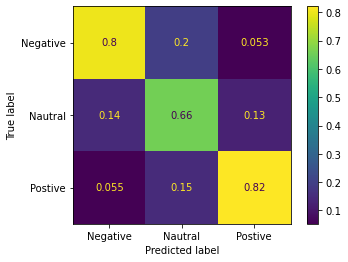

In [12]:
# Generate confusion matrix plot

cf_matrix = confusion_matrix(y_test, predictions, normalize='pred')
display_labels = ['Negative', 'Nautral','Postive']
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=display_labels)
disp.plot()

#We observe the classifaction some how is good, but tough for nautral classifaction.

In [13]:
def predict(String):
    prediction = model.predict(vect.transform([String]))
    if prediction ==-1:
        print('Negative rating')
    elif prediction==0: 
        print('Neutral rating') 
    else:
        print('Postive rating')
    


Testing different reviews (From Amazon.com, 2021):

In [17]:
predict("This is honestly the best snack box ever , perfect for movie night or work snacks etc I bought myself one and my mom one and we went through it so fast . Definitely will be purchasing again! It's honestly a great deal and is very versatile . I would upload a photo but I already ate it all ! LolI rely on reviews when I make purchases so I put a lot of time into reviewing everything I buy on Amazon for personal and my business. Please show your appreciation by clicking the \"helpful\" below when it asks if the review is helpful!!!")

Postive rating


In [15]:
predict("All the packages are expired. Even outside label shows use by July 3rd. Today is Sept. 6th.")

Negative rating


In [18]:
predict("Great delivery and awesome looking pkg, but all the chips, pretzels, and half the nuts were well past their “Best By” dates. I’m not in the habit of buying”expired” food and will not order again.")

Negative rating


In [19]:
predict("Overall, I have mixed feelings about the purchase of this product. The selection and count was great for the price. The individual packages were great as well as a parent of two young children. My reason for the three star rating is that once we received this item, most of the chips were expiring within a week or two. I'm not sure if I'm the only one that experienced this, but it is definitely something to consider before purchasing.")

Neutral rating


In [20]:
predict("I ordered these for my classroom. I need snacks throughout the day and I often have a hungry student who could use a snack. They were great until after a couple of months something I ate tasted funny. I looked at the date and it had been past its suggested freshness for over a month already. I did not have the snacks too long and was a little irritated that they were already going bad. I will look for other options or just grab stuff from my local warehouse store.")

Neutral rating
